In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cpe232-dataset/sample_submission.csv
/kaggle/input/cpe232-dataset/train.csv
/kaggle/input/cpe232-dataset/test.csv
/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv


## Datasets Preparation

In [15]:
from termcolor import colored
from IPython.display import clear_output
from tqdm import tqdm, trange

import numpy as np
import pandas as pd
import math
import datetime
import sys

import matplotlib
import matplotlib as mpl
import matplotlib.cm as cmap
import matplotlib.colors as mpl_colors
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

In [1]:
PROBLEM = 'classification'

def load_datasets():
    train = pd.read_csv('/kaggle/input/cpe232-dataset/train.csv')
    test = pd.read_csv('/kaggle/input/cpe232-dataset/test.csv')
    sample_sub = pd.read_csv('/kaggle/input/cpe232-dataset/sample_submission.csv')
    original = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')
    
    train = train.drop(['id'], axis=1)
    test = test.drop(['id'], axis=1)
    return train, test, original, sample_sub

TARGET = 'loan_status'

def SCORE(labels, proba):
    return roc_auc_score(labels, proba)

def LOSS(labels, proba):
    return -roc_auc_score(labels, proba)

SCORE_NAME = 'ROC_AUC'

OOF_TRAIN_NAME, OOF_TRUE_NAME, OOF_TEST_NAME = 'oof_train_proba', 'oof_true', 'test_proba_mean'

In [11]:
def fcn(df):
    return df.columns.tolist(), df.select_dtypes(include=['object', 'category']).columns.tolist(), df.select_dtypes(exclude=['object', 'category']).columns.tolist()   

def df_info(df, name='', tab=True, plots=False, info=True, nrows=3):
    print(colored(f'\n---------- {name} ----------:\n', 'red'))
    
    if tab:
        display(df.head(nrows))
        display(df.tail(nrows))
        print(colored(f'{name} has {df.shape[0]} rows, {df.shape[1]} columns\n', 'blue'))

    inf = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index':'column', 0:'type'})
    df_missed = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index':'column', 0:'missed'})
    df_unique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index':'column', 0:'unique'})
    inf['missed'] = df_missed['missed']
    inf['unique'] = df_unique['unique']
    inf['duplicate'] = df.duplicated().sum()
    
    desc = pd.DataFrame(df.describe(include='all').transpose())
    if 'min' in desc.columns.tolist():
        inf['min'] = desc['min'].values
        inf['max'] = desc['max'].values
        inf['avg'] = desc['mean'].values
        inf['std dev'] = desc['std'].values
    if 'top' in desc.columns.tolist():
        inf['top value'] = desc['top'].values
        inf['Freq'] = desc['freq'].values    
    
    if info:
        display(inf.style.background_gradient(subset='missed', cmap='Reds').background_gradient(subset='unique', cmap='Greens'))
  
    if plots:
        print()
        if df_missed['missed'].sum() > 0:
            fig, ax = plt.subplots(1, 1, figsize=(24, 5))
            sns.barplot(df_missed[df_missed['missed'] > 0], x='column', y='missed', ax=ax)
            ax.set_title(f'{name} missed values') 
            ax.bar_label(ax.containers[0])
            plt.tight_layout()
            plt.show()

        fig, ax = plt.subplots(1, 1, figsize=(24, 5))
        sns.barplot(df_unique[df_unique['unique'] > 0], x='column', y='unique', ax=ax)
        ax.set_title(f'{name} unique values')
        ax.bar_label(ax.containers[0])
        plt.tight_layout()
        plt.show()

# !pip install dython
from dython.nominal import associations

def df_corr(df, name=''):
    associations_df = associations(df, nominal_columns='all', plot=False)
    corr_matrix = associations_df['corr']
    plt.figure(figsize=(20, 8))
    plt.gcf().set_facecolor('#FFFDD0') 
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
    plt.title(f'{name} Correlation Matrix including Categorical Features')
    plt.show()

In [4]:
train, test, original, sample_sub = load_datasets()

In [8]:
cols, _, _  = fcn(test)
for df in [train, test, original]:
    for c in cols:
        for prfx in ['cb_', 'person_', 'loan_']:
            if c.startswith(prfx):
                df.rename(columns={c:c[len(prfx):]}, inplace=True)
cols, _, _  = fcn(test)                
for df in [train, test, original]:
    for c in cols:
        for prfx in ['cb_', 'person_', 'loan_']:
            if c.startswith(prfx):
                df.rename(columns={c:c[len(prfx):]}, inplace=True)
                
if original is not None:
    train['original'] = False
    test['original'] = False
    original['original'] = True


---------- TRAIN ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original
0,26.0,34427.0,RENT,5.946998,DEBTCONSOLIDATION,E,19270.0,11.272717,0.193133,Y,4.0,1,False
1,32.0,91102.0,MORTGAGE,8.527473,VENTURE,B,19815.0,12.831859,0.183127,N,4.0,0,False
2,25.0,25847.0,RENT,4.919103,PERSONAL,D,10043.0,15.532120,0.241554,Y,3.0,0,False


/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original
39547,29.0,47254.0,RENT,5.898234,PERSONAL,C,19525.0,11.827926,0.332164,Y,7.0,1,False
39548,23.0,24691.0,RENT,4.929896,PERSONAL,D,7148.0,16.854522,0.231152,Y,3.0,1,False
39549,23.0,NaN,RENT,0.695977,DEBTCONSOLIDATION,C,12050.0,NaN,NaN,Y,4.0,1,False


TRAIN has 39550 rows, 13 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,1085,46,0,21.000000,66.000000,27.972650,6.273788,nan,nan
1,income,float64,1058,30524,0,11664.000000,249272.000000,60092.694300,31180.309540,nan,nan
2,home_ownership,object,1091,4,0,nan,nan,nan,nan,RENT,24431
3,emp_length,float64,1043,38505,0,0.000046,25.100039,5.201428,3.437699,nan,nan
4,intent,object,1049,6,0,nan,nan,nan,nan,VENTURE,9320
5,grade,object,1093,7,0,nan,nan,nan,nan,A,11348
6,amnt,float64,1081,13722,0,118.000000,36213.000000,9349.245782,5696.712524,nan,nan
7,int_rate,float64,1077,38471,0,4.917300,22.969506,11.777246,3.674727,nan,nan
8,percent_income,float64,1090,38458,0,0.000473,0.552968,0.163219,0.100170,nan,nan
9,default_on_file,object,1065,2,0,nan,nan,nan,nan,N,28139


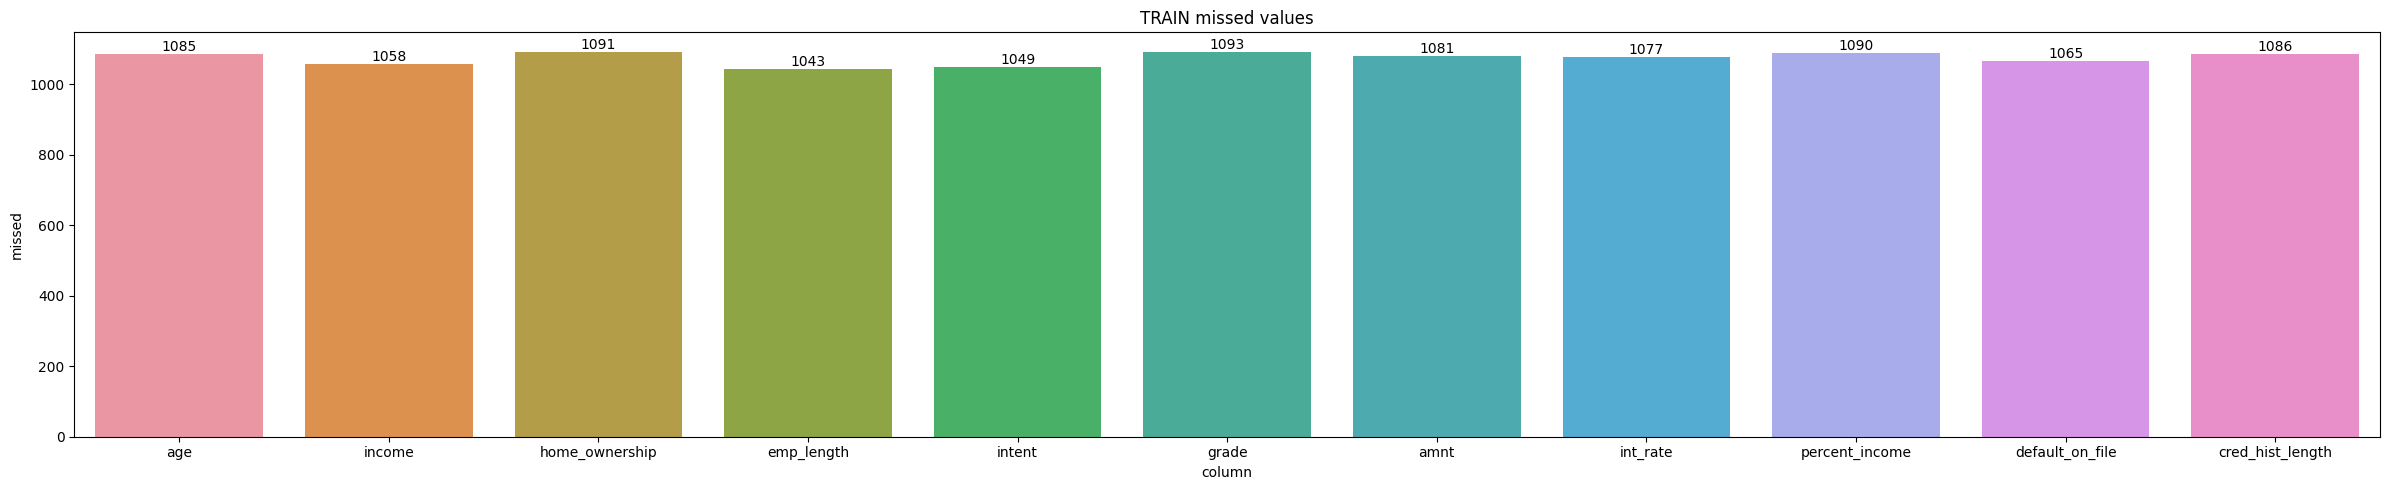

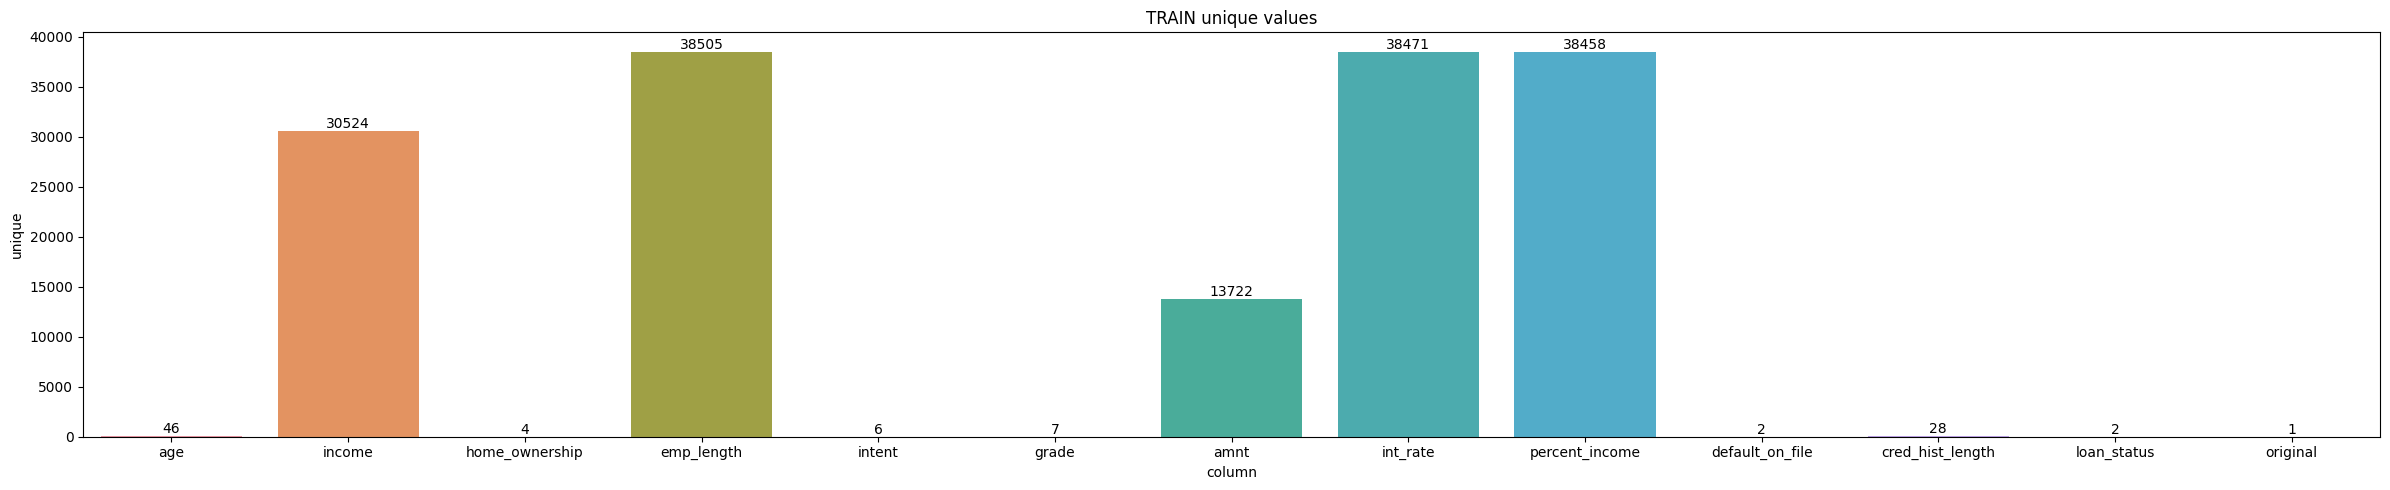


---------- TEST ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original
0,22.0,30330.0,RENT,6.221275,MEDICAL,C,19989.0,14.713760,0.377784,Y,4.0,False
1,31.0,79403.0,MORTGAGE,9.876324,VENTURE,A,11849.0,10.467577,0.135866,N,10.0,False
2,25.0,26966.0,RENT,2.643441,MEDICAL,C,8481.0,14.937696,0.036416,N,4.0,False


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original
16947,32.0,34982.0,RENT,11.262266,VENTURE,C,7466.0,11.103200,0.201933,N,6.0,False
16948,22.0,50063.0,OTHER,0.038280,DEBTCONSOLIDATION,B,11867.0,11.528317,0.228862,N,4.0,False
16949,31.0,76258.0,MORTGAGE,10.285255,VENTURE,D,4598.0,13.463073,0.063503,N,7.0,False


TEST has 16950 rows, 12 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,313,45,0,21.000000,68.000000,27.971870,6.230354,nan,nan
1,income,float64,276,15026,0,13877.000000,232157.000000,60425.057994,31404.519980,nan,nan
2,home_ownership,object,323,4,0,nan,nan,nan,nan,RENT,10567
3,emp_length,float64,315,16634,0,0.000147,27.538655,5.277007,3.477568,nan,nan
4,intent,object,283,6,0,nan,nan,nan,nan,VENTURE,3936
5,grade,object,311,7,0,nan,nan,nan,nan,A,4924
6,amnt,float64,301,9307,0,99.000000,35949.000000,9337.621479,5684.450366,nan,nan
7,int_rate,float64,296,16654,0,5.066233,22.916453,11.782521,3.697997,nan,nan
8,percent_income,float64,310,16638,0,0.002781,0.554049,0.161265,0.099021,nan,nan
9,default_on_file,object,334,2,0,nan,nan,nan,nan,N,12136


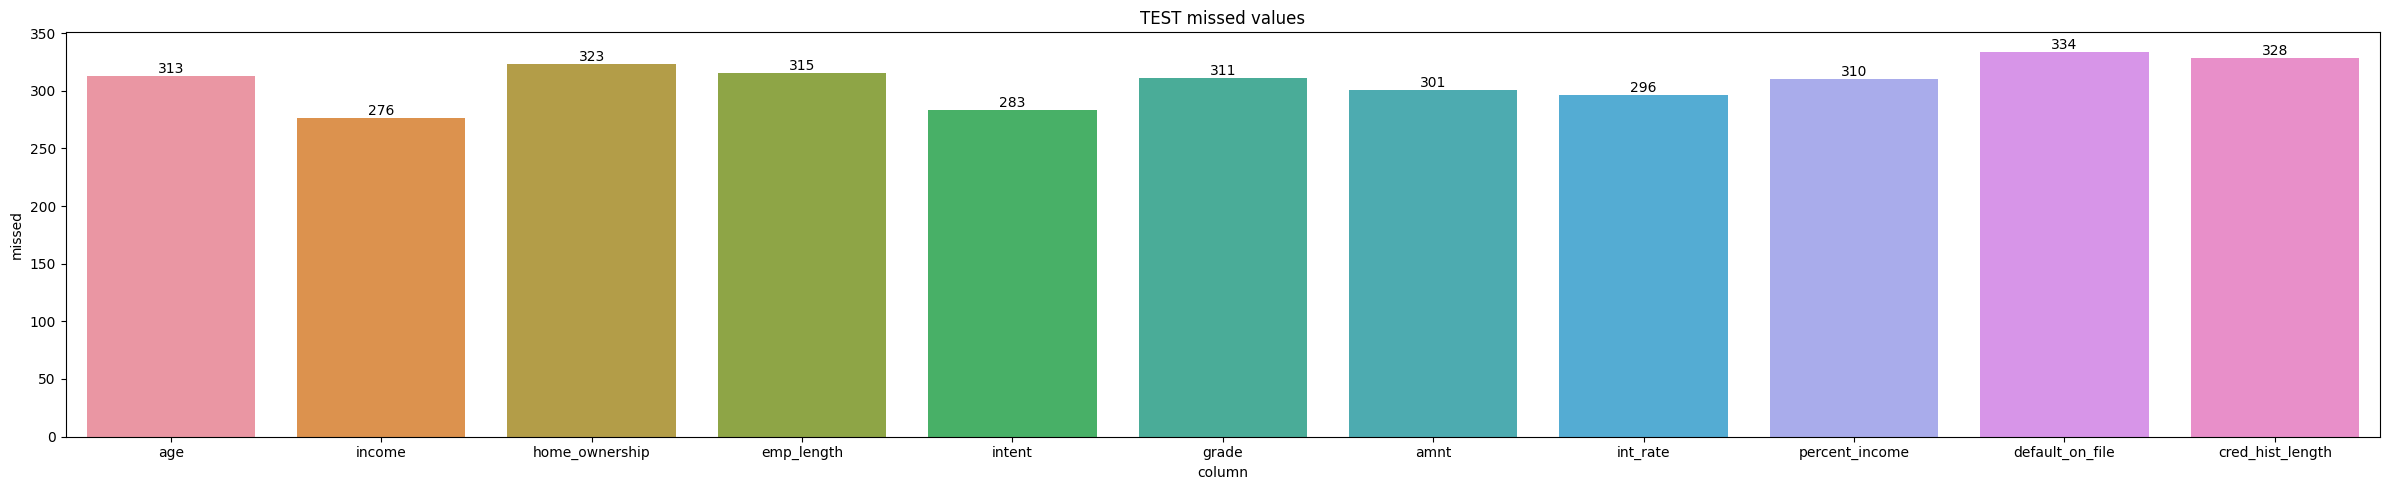

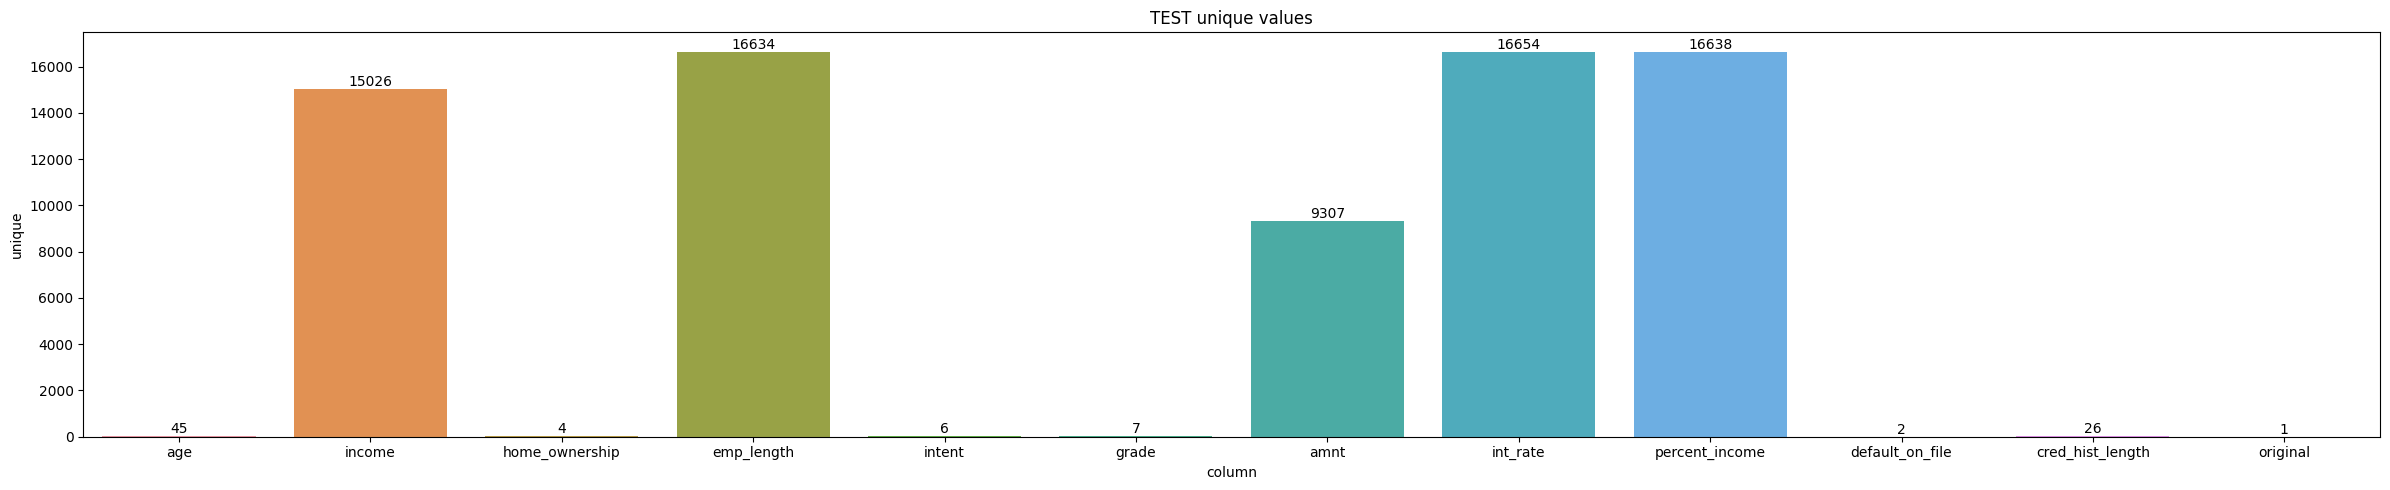


---------- ORIGINAL ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,loan_status,percent_income,default_on_file,cred_hist_length,original
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3,True
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2,True
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3,True


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,loan_status,percent_income,default_on_file,cred_hist_length,original
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28,True
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26,True
32580,66,42000,RENT,2.0,MEDICAL,B,6475,9.99,0,0.15,N,30,True


ORIGINAL has 32581 rows, 13 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,int64,0,58,165,20.000000,144.000000,27.734600,6.348078,nan,nan
1,income,int64,0,4295,165,4000.000000,6000000.000000,66074.848470,61983.119168,nan,nan
2,home_ownership,object,0,4,165,nan,nan,nan,nan,RENT,16446
3,emp_length,float64,895,36,165,0.000000,123.000000,4.789686,4.142630,nan,nan
4,intent,object,0,6,165,nan,nan,nan,nan,EDUCATION,6453
5,grade,object,0,7,165,nan,nan,nan,nan,A,10777
6,amnt,int64,0,753,165,500.000000,35000.000000,9589.371106,6322.086646,nan,nan
7,int_rate,float64,3116,348,165,5.420000,23.220000,11.011695,3.240459,nan,nan
8,loan_status,int64,0,2,165,0.000000,1.000000,0.218164,0.413006,nan,nan
9,percent_income,float64,0,77,165,0.000000,0.830000,0.170203,0.106782,nan,nan


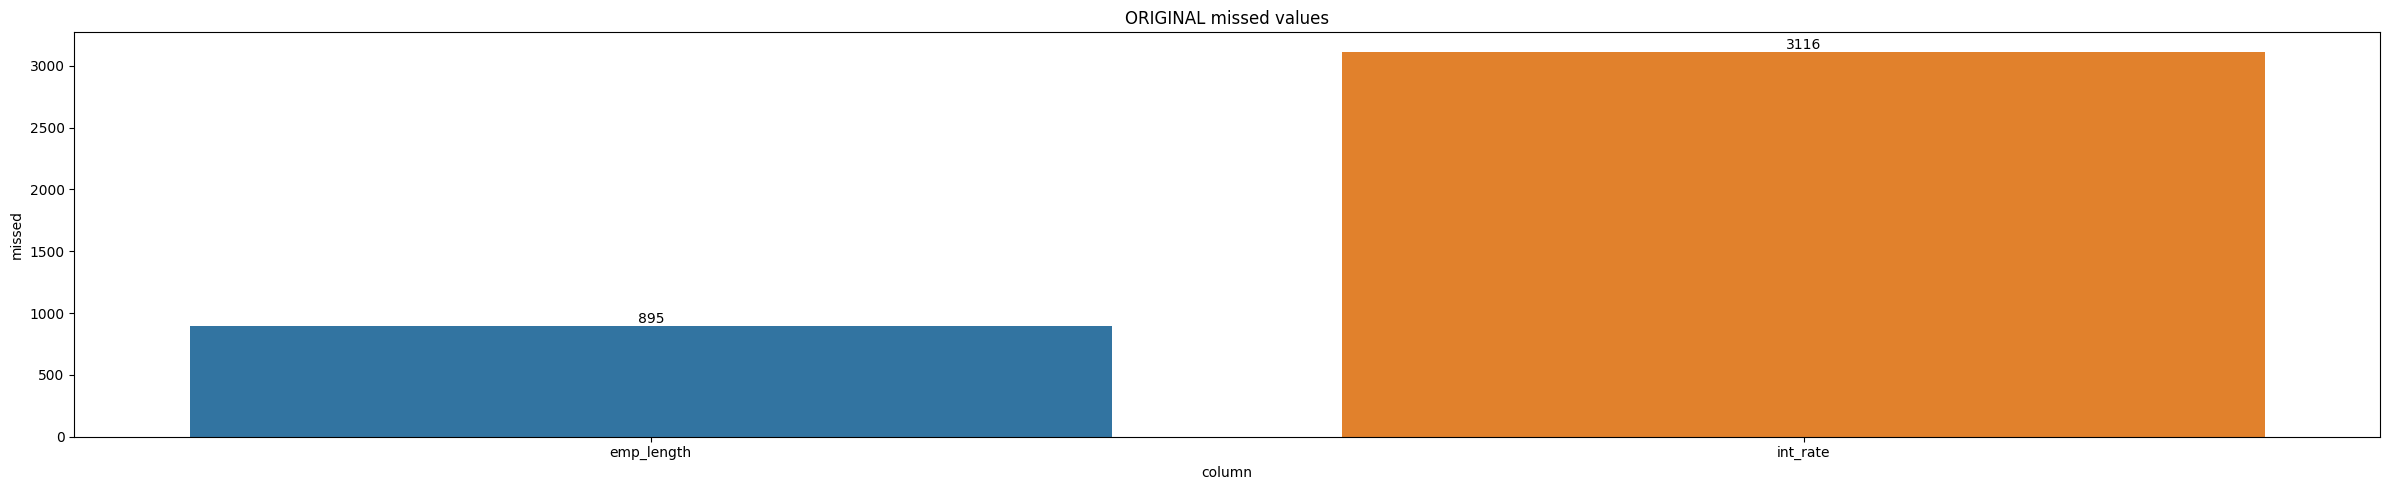

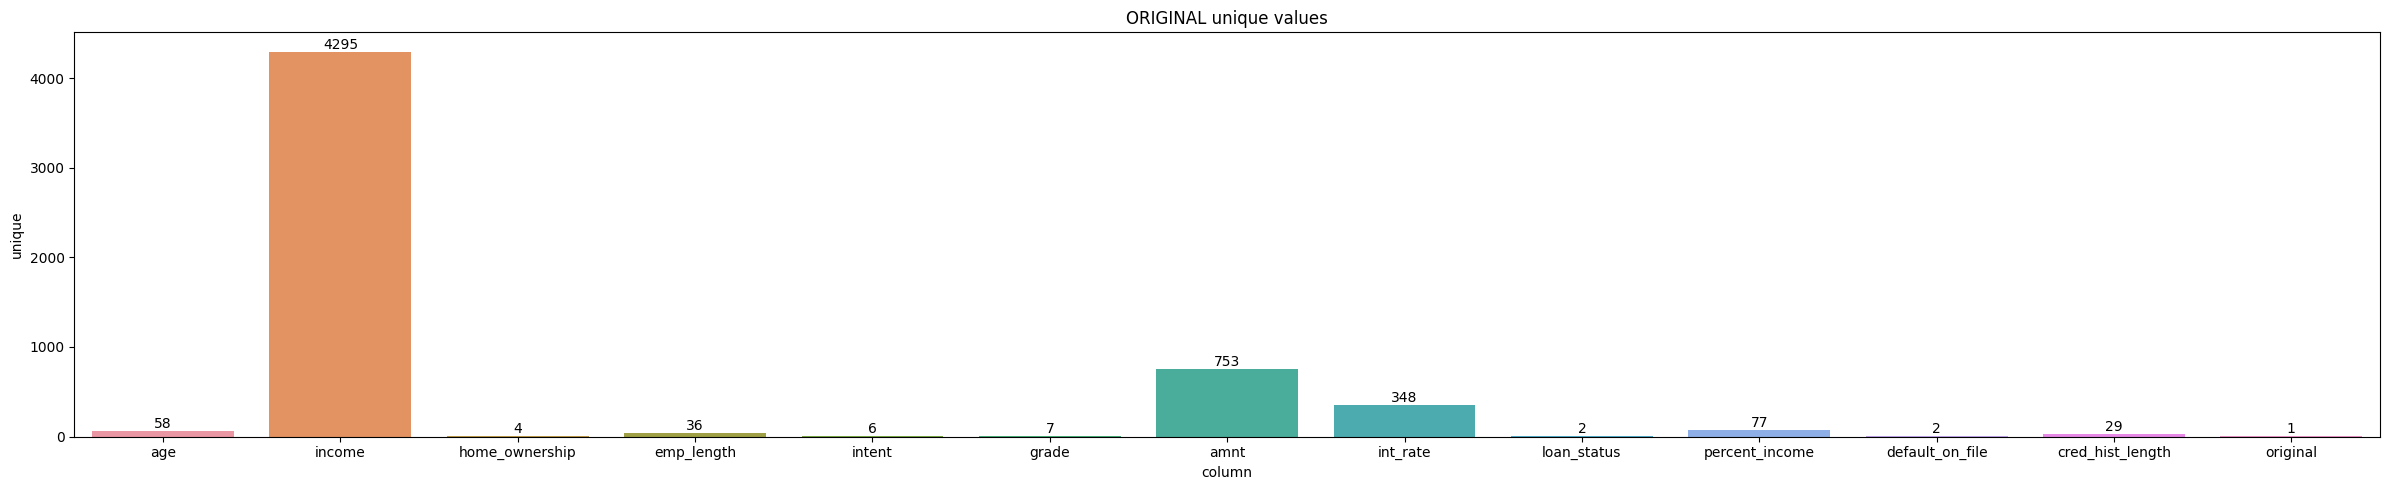

In [16]:
df_info(train, 'TRAIN', plots=True)
df_info(test, 'TEST', plots=True)
if original is not None:
    df_info(original, 'ORIGINAL', plots=True)

## Data Visualization

In [ ]:
import matplotlib.pyplot as plt

# Plot histograms for all columns
for column in df.columns:
    plt.figure(figsize=(6, 4))
    if df[column].dtype == 'object':  # Categorical column
        df[column].value_counts().plot(kind='bar', color='skyblue')
        plt.title(f'Distribution of {column} (Categorical)')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    else:  # Numerical column
        df[column].plot(kind='hist', bins=10, color='lightgreen', edgecolor='black')
        plt.title(f'Distribution of {column} (Numerical)')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    plt.grid(axis='y')
    plt.show()

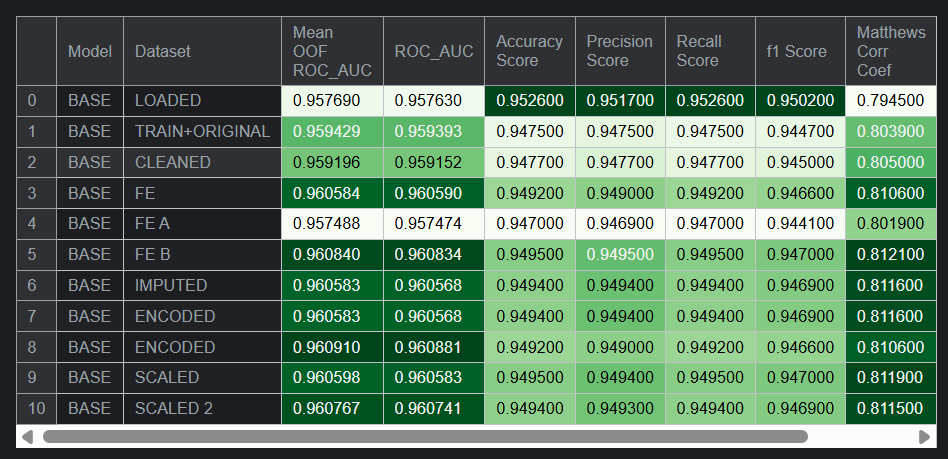

Credit : https://www.kaggle.com/code/martynovandrey/eda-and-lgb-cat-xgb#%F0%9F%93%8A-EDA

## Data Preprocess

* Add the original data

In [17]:
def add_original(train_, original_):
    f = train_.columns.tolist()
    train = pd.concat([train_, original_[f]], axis=0, ignore_index=True).reset_index(drop=True)
    return train

In [18]:
if original is not None:
    train_add = add_original(train, original)  

* Clean the outlier

In [19]:
def clean(train_, test_):     
    train, test = train_.copy(), test_.copy()
    
    train = train.drop(train[train['age'] > 100].index)
    train = train.drop(train[train['emp_length'] > 100].index)
    train = train.reset_index(drop=True)
    
#     train = train.drop_duplicates(ignore_index=True)
    
#     int_rate_mean = train['int_rate'].mean()
#     k = train['emp_length'].mean() / train['age'].mean()
#     for df in [train, test]:
#         df['age'] = np.clip(df['age'], 15, 70) 
#         df['emp_length'] = np.clip(df['emp_length'], 0, 40) 
#         df['int_rate'] = int_rate_mean
#         df['emp_length'] = df['emp_length'].fillna(df['age'] * k)
    return train, test

train_cleaned, test_cleaned = clean(train_add, test)

/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


* Feature Engineering

In [20]:
def feature_engineering(df_):  
    df = df_.copy()
    df['loantoincome'] = (df['amnt'] / df['income']) - df['percent_income']
    df['income'] = np.log(df['income'])
    return df

train_fe, test_fe = feature_engineering(train_cleaned), feature_engineering(test_cleaned)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


* Imputed

In [21]:
def impute(df_):
    df = df_.copy()
    _, category_columns, nums = fcn(df)
    df[category_columns] = df[category_columns].astype('object').fillna('none').astype('category')
    df[nums] = df[nums].fillna(0)
    return df

train_imputed = impute(train_fe)
test_imputed = impute(test_fe)

df_info(train_imputed, 'TRAIN IMPUTED', tab=False, plots=False)
df_info(test_imputed, 'TEST IMPUTED', tab=False, plots=False)


---------- TRAIN IMPUTED ----------:



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,57,165,0.000000,94.000000,27.437025,7.063537,nan,nan
1,income,float64,0,33495,165,0.000000,14.528354,10.745687,1.407823,nan,nan
2,home_ownership,category,0,5,165,nan,nan,nan,nan,RENT,40873
3,emp_length,float64,0,38540,165,0.000000,41.000000,4.877466,3.762924,nan,nan
4,intent,category,0,7,165,nan,nan,nan,nan,VENTURE,15036
5,grade,category,0,8,165,nan,nan,nan,nan,A,22124
6,amnt,float64,0,14036,165,0.000000,36213.000000,9316.957407,6056.778597,nan,nan
7,int_rate,float64,0,38820,165,0.000000,23.220000,10.779971,4.335766,nan,nan
8,percent_income,float64,0,38535,165,0.000000,0.830000,0.163906,0.104508,nan,nan
9,default_on_file,category,0,3,165,nan,nan,nan,nan,N,54969



---------- TEST IMPUTED ----------:



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,46,0,0.000000,68.000000,27.455339,7.230687,nan,nan
1,income,float64,0,15027,0,0.000000,12.355169,10.716353,1.456456,nan,nan
2,home_ownership,category,0,5,0,nan,nan,nan,nan,RENT,10567
3,emp_length,float64,0,16635,0,0.000000,27.538655,5.178939,3.518045,nan,nan
4,intent,category,0,7,0,nan,nan,nan,nan,VENTURE,3936
5,grade,category,0,8,0,nan,nan,nan,nan,A,4924
6,amnt,float64,0,9308,0,0.000000,35949.000000,9171.802950,5767.154347,nan,nan
7,int_rate,float64,0,16655,0,0.000000,22.916453,11.576761,3.977251,nan,nan
8,percent_income,float64,0,16639,0,0.000000,0.554049,0.158315,0.100463,nan,nan
9,default_on_file,category,0,3,0,nan,nan,nan,nan,N,12136


* Ordinal Encoder

In [23]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
train_encoded, test_encoded = train_imputed.copy(), test_imputed.copy()

category_columns = test_encoded.select_dtypes(include=['object', 'category']).columns.tolist()
tmp_df = pd.concat([train_encoded, test_encoded], axis='rows')
tmp_df[category_columns] = encoder.fit_transform(tmp_df[category_columns])
train_encoded[category_columns] = encoder.transform(train_encoded[category_columns])
train_encoded[category_columns] = train_encoded[category_columns].astype('int32').astype('category')
test_encoded[category_columns] = encoder.transform(test_encoded[category_columns])
test_encoded[category_columns] = test_encoded[category_columns].astype('int32').astype('category')

df_info(train_encoded, 'TRAIN ENCODED', tab=True, plots=False)
df_info(test_encoded, 'TEST ENCODED', tab=True, plots=False)


---------- TRAIN ENCODED ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original,loantoincome
0,26.0,10.446596,3,5.946998,0,4,19270.0,11.272717,0.193133,1,4.0,1,False,0.366602
1,32.0,11.419735,0,8.527473,5,1,19815.0,12.831859,0.183127,0,4.0,0,False,0.034377
2,25.0,10.159950,3,4.919103,4,3,10043.0,15.532120,0.241554,1,3.0,0,False,0.147002


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original,loantoincome
72121,65.0,11.238489,3,3.0,2,1,35000.0,10.99,0.46,0,28.0,1,True,0.000526
72122,56.0,11.918391,0,5.0,4,1,15000.0,11.48,0.10,0,26.0,0,True,0.000000
72123,66.0,10.645425,3,2.0,3,1,6475.0,9.99,0.15,0,30.0,0,True,0.004167


TRAIN ENCODED has 72124 rows, 14 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,57,165,0.000000,94.000000,27.437025,7.063537,nan,nan
1,income,float64,0,33495,165,0.000000,14.528354,10.745687,1.407823,nan,nan
2,home_ownership,category,0,5,165,nan,nan,nan,nan,3.000000,40873.000000
3,emp_length,float64,0,38540,165,0.000000,41.000000,4.877466,3.762924,nan,nan
4,intent,category,0,7,165,nan,nan,nan,nan,5.000000,15036.000000
5,grade,category,0,8,165,nan,nan,nan,nan,0.000000,22124.000000
6,amnt,float64,0,14036,165,0.000000,36213.000000,9316.957407,6056.778597,nan,nan
7,int_rate,float64,0,38820,165,0.000000,23.220000,10.779971,4.335766,nan,nan
8,percent_income,float64,0,38535,165,0.000000,0.830000,0.163906,0.104508,nan,nan
9,default_on_file,category,0,3,165,nan,nan,nan,nan,0.000000,54969.000000



---------- TEST ENCODED ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original,loantoincome
0,22.0,10.319893,3,6.221275,3,2,19989.0,14.713760,0.377784,1,4.0,False,0.281266
1,31.0,11.282291,0,9.876324,5,0,11849.0,10.467577,0.135866,0,10.0,False,0.013360
2,25.0,10.202332,3,2.643441,3,2,8481.0,14.937696,0.036416,0,4.0,False,0.278091


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original,loantoincome
16947,32.0,10.462589,3,11.262266,5,2,7466.0,11.103200,0.201933,0,6.0,False,0.011491
16948,22.0,10.821037,1,0.038280,0,1,11867.0,11.528317,0.228862,0,4.0,False,0.008179
16949,31.0,11.241878,0,10.285255,5,3,4598.0,13.463073,0.063503,0,7.0,False,-0.003208


TEST ENCODED has 16950 rows, 13 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,46,0,0.000000,68.000000,27.455339,7.230687,nan,nan
1,income,float64,0,15027,0,0.000000,12.355169,10.716353,1.456456,nan,nan
2,home_ownership,category,0,5,0,nan,nan,nan,nan,3.000000,10567.000000
3,emp_length,float64,0,16635,0,0.000000,27.538655,5.178939,3.518045,nan,nan
4,intent,category,0,7,0,nan,nan,nan,nan,5.000000,3936.000000
5,grade,category,0,8,0,nan,nan,nan,nan,0.000000,4924.000000
6,amnt,float64,0,9308,0,0.000000,35949.000000,9171.802950,5767.154347,nan,nan
7,int_rate,float64,0,16655,0,0.000000,22.916453,11.576761,3.977251,nan,nan
8,percent_income,float64,0,16639,0,0.000000,0.554049,0.158315,0.100463,nan,nan
9,default_on_file,category,0,3,0,nan,nan,nan,nan,0.000000,12136.000000


* Scaling

In [26]:
from sklearn.preprocessing import StandardScaler

train_scaled, test_scaled = train_encoded.copy(), test_encoded.copy()
features, cats, nums = fcn(test_scaled)
scaler = StandardScaler()
train_scaled[nums] = scaler.fit_transform(train_scaled[nums])
test_scaled[nums] = scaler.transform(test_scaled[nums])

In [28]:
def scale2(train_, test_):
    train, test = train_.copy(), test_.copy()
    
    features, cats, nums = fcn(test_scaled)

    TRAIN_LN = len(train)
    test[TARGET] = 0
    train = pd.concat([train,test],axis=0,ignore_index=True)   

    # STANDARIZE NUMERICAL FEATURES
    for c in nums:
        print(c,', ',end='')
        m = train[c].mean()
        s = train[c].std()
        train[c] = (train[c]-m)/s
        train[c] = train[c].fillna(0) 
        
    test = train.iloc[TRAIN_LN:]
    train = train.iloc[:TRAIN_LN]
        
    for c in cats:
        train[c] =  train[c].astype('category')
        test[c] =  test[c].astype('category')
    return train, test[features]

train_scaled2, test_scaled2 = scale2(train_encoded, test_encoded)

df_info(train_scaled2, 'TRAIN SCALED2', tab=True, plots=False)
df_info(test_scaled2, 'TEST SCALED2', tab=True, plots=False)

age , income , emp_length , amnt , int_rate , percent_income , cred_hist_length , original , loantoincome , 
---------- TRAIN SCALED2 ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original,loantoincome
0,-0.203014,-0.207098,3,0.272129,0,4,1.662618,0.079678,0.291901,1,-0.412117,1,-0.759292,3.895757
1,0.642579,0.479543,0,0.965911,5,1,1.753406,0.443854,0.195473,0,-0.412117,0,-0.759292,0.212103
2,-0.343946,-0.409355,3,-0.004230,4,3,0.125548,1.074568,0.758502,1,-0.660408,0,-0.759292,1.460872


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,loan_status,original,loantoincome
72121,5.293342,0.351657,3,-0.520196,2,1,4.282983,0.013642,2.863544,0,5.546877,1,1.317001,-0.163223
72122,4.024952,0.831392,0,0.017520,4,1,0.951305,0.128094,-0.605574,0,5.050295,0,1.317001,-0.169059
72123,5.434274,-0.066806,3,-0.789054,3,1,-0.468823,-0.219933,-0.123752,0,6.043460,0,1.317001,-0.122860


TRAIN SCALED2 has 72124 rows, 14 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,57,165,-3.867252,9.380376,-0.000491,0.995480,nan,nan
1,income,float64,0,33495,165,-7.578162,2.672969,0.003939,0.993352,nan,nan
2,home_ownership,category,0,5,165,nan,nan,nan,nan,3.000000,40873.000000
3,emp_length,float64,0,38540,165,-1.326771,9.696416,-0.015424,1.011693,nan,nan
4,intent,category,0,7,165,nan,nan,nan,nan,5.000000,15036.000000
5,grade,category,0,8,165,nan,nan,nan,nan,0.000000,22124.000000
6,amnt,float64,0,14036,165,-1.547454,4.485049,0.004601,1.008962,nan,nan
7,int_rate,float64,0,38820,165,-2.553346,2.870264,-0.035415,1.012726,nan,nan
8,percent_income,float64,0,38535,165,-1.569217,6.429026,0.010252,1.007081,nan,nan
9,default_on_file,category,0,3,165,nan,nan,nan,nan,0.000000,54969.000000



---------- TEST SCALED2 ----------:



,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original,loantoincome
72124,-0.766743,-0.296500,3,0.34587,3,2,1.782392,0.883419,2.071277,1,-0.412117,-0.759292,2.949572
72125,0.501647,0.382564,0,1.32856,5,0,0.426399,-0.108383,-0.259949,0,1.077632,-0.759292,-0.020929
72126,-0.343946,-0.379450,3,-0.61606,3,2,-0.134656,0.935725,-1.218298,0,-0.412117,-0.759292,2.914369


,age,income,home_ownership,emp_length,intent,grade,amnt,int_rate,percent_income,default_on_file,cred_hist_length,original,loantoincome
89071,0.642579,-0.195814,3,1.701182,5,2,-0.303738,0.040083,0.376696,0,0.084466,-0.759292,-0.041647
89072,-0.766743,0.057105,1,-1.316479,0,1,0.429397,0.139380,0.636199,0,-0.412117,-0.759292,-0.078370
89073,0.501647,0.354048,0,1.438505,5,3,-0.781501,0.591290,-0.957272,0,0.332757,-0.759292,-0.204628


TEST SCALED2 has 16950 rows, 13 columns



,column,type,missed,unique,duplicate,min,max,avg,std dev,top value,Freq
0,age,float64,0,46,0,-3.867252,5.716138,0.002090,1.019037,nan,nan
1,income,float64,0,15027,0,-7.578162,1.139581,-0.016759,1.027668,nan,nan
2,home_ownership,category,0,5,0,nan,nan,nan,nan,3.000000,10567.000000
3,emp_length,float64,0,16635,0,-1.326771,6.077223,0.065630,0.945855,nan,nan
4,intent,category,0,7,0,nan,nan,nan,nan,5.000000,3936.000000
5,grade,category,0,8,0,nan,nan,nan,nan,0.000000,4924.000000
6,amnt,float64,0,9308,0,-1.547454,4.441071,-0.019579,0.960715,nan,nan
7,int_rate,float64,0,16655,0,-2.553346,2.799363,0.150695,0.928986,nan,nan
8,percent_income,float64,0,16639,0,-1.569217,3.769838,-0.043623,0.968106,nan,nan
9,default_on_file,category,0,3,0,nan,nan,nan,nan,0.000000,12136.000000


In [29]:
train_final, test_final, dataset = train_scaled2.copy(), test_scaled2.copy(), 'SCALED2'

In [33]:
train_final['loan_status'].value_counts()

loan_status
0    54964
1    17160
Name: count, dtype: int64

## Approach 1 : Catboost + Optuna

In [ ]:
!pip install catboost

In [ ]:
!pip install optuna

In [60]:
from catboost import CatBoostClassifier, Pool
import pandas as pd

# Splitting the data into training and test sets (if needed)
from sklearn.model_selection import train_test_split
X = train_final.drop(columns=['loan_status'])  # Drop 'loan_status' from the features
y = train_final['loan_status']  # Set 'loan_status' as the target variable

In [61]:
y.value_counts()

loan_status
0    54964
1    17160
Name: count, dtype: int64

## 1.1 Normal without the undersampling

In [62]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm for progress tracking

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    # Initialize CatBoostClassifier with suggested hyperparameters
    model = CatBoostClassifier(
        **param,
        cat_features=cat_features,
        verbose=0  # Disable verbose output
    )

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    # Use tqdm to track the progress of K-Fold Cross-Validation
    for train_idx, val_idx in tqdm(skf.split(X, y), desc="K-Fold Progress"):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate accuracy
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
    
    # Return the mean accuracy across all folds
    return sum(accuracies) / len(accuracies)

# Create Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50, timeout=1800)  # Adjust trials and timeout as needed

# Best trial
print("Best hyperparameters:", study.best_params)
print("Best accuracy (Cross-Validation):", study.best_value)

[I 2025-03-23 05:14:31,741] A new study created in memory with name: no-name-9f6182e7-73d8-44e4-9c51-a8444c0d954c
K-Fold Progress: 5it [07:15, 87.12s/it]
[I 2025-03-23 05:21:47,347] Trial 0 finished with value: 0.8831734678674383 and parameters: {'iterations': 2097, 'learning_rate': 0.13534855011172628, 'depth': 7, 'l2_leaf_reg': 0.16115417925871467, 'bagging_temperature': 0.17483265164564776, 'random_strength': 4.997588708858207, 'border_count': 202}. Best is trial 0 with value: 0.8831734678674383.
K-Fold Progress: 5it [02:25, 29.20s/it]
[I 2025-03-23 05:24:13,330] Trial 1 finished with value: 0.8865842592405686 and parameters: {'iterations': 1261, 'learning_rate': 0.02038097711438441, 'depth': 4, 'l2_leaf_reg': 0.02562003790317575, 'bagging_temperature': 0.7205547831164737, 'random_strength': 0.0010970205203115313, 'border_count': 65}. Best is trial 1 with value: 0.8865842592405686.
K-Fold Progress: 5it [03:56, 47.20s/it]
[I 2025-03-23 05:28:09,347] Trial 2 finished with value: 0.887

Best hyperparameters: {'iterations': 1741, 'learning_rate': 0.003525649240260784, 'depth': 8, 'l2_leaf_reg': 0.05537154937043524, 'bagging_temperature': 0.6004150149844999, 'random_strength': 0.22832285823620574, 'border_count': 252}
Best accuracy (Cross-Validation): 0.8882896424311107


Best hyperparameters: {'iterations': 1741, 'learning_rate': 0.003525649240260784, 'depth': 8, 'l2_leaf_reg': 0.05537154937043524, 'bagging_temperature': 0.6004150149844999, 'random_strength': 0.22832285823620574, 'border_count': 252}
Best accuracy (Cross-Validation): 0.8882896424311107

Fit the model

In [64]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = CatBoostClassifier(**best_params, cat_features=cat_features, verbose=0)

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Prepare feature matrix and target variable
X = train_final.drop(columns=['loan_status'])  # Drop 'loan_status' from the features
y = train_final['loan_status']  # Set 'loan_status' as the target variable

# Identify categorical columns
cat_features = [col for col in X.columns if str(X[col].dtype) == 'category']

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

# Use tqdm to track the progress of K-Fold Cross-Validation
for train_idx, val_idx in tqdm(skf.split(X, y), desc="K-Fold Progress"):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train the model
    final_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = final_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Output the mean accuracy across all folds
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy (Cross-Validation): {mean_accuracy}")

K-Fold Progress: 5it [07:00, 84.06s/it]

Mean accuracy (Cross-Validation): 0.8882896424311107


Submission for normal

In [65]:
# Predict on the test dataset
test_predictions = final_model.predict(test_final)

sample_df = pd.read_csv('/kaggle/input/cpe232-dataset/sample_submission.csv')

# Create a submission DataFrame
submission = pd.DataFrame({
    # 'id': test_final['id'],  # Ensure your test_df has an 'Id' column
    'id': sample_df['ID'],
    'loan_status': test_predictions
})

# Save to CSV
submission.to_csv('submission_normal_kfold.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


### 0.65 - The resampling is better

## 1.2 Catboost Resampling Training

In [38]:
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd

# Initialize the undersampler
undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

# Apply undersampling
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Combine resampled data into a new DataFrame
df_resampled = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['loan_status'])], axis=1)

print("Class distribution after undersampling:")
print(df_resampled['loan_status'].value_counts())

Class distribution after undersampling:
loan_status
0    17160
1    17160
Name: count, dtype: int64


In [46]:
# Identify categorical columns
cat_features = [col for col in X_resam.columns if str(X_resam[col].dtype) == 'category']

In [47]:
cat_features

['home_ownership', 'intent', 'grade', 'default_on_file']

In [48]:
import optuna
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm  # Import tqdm for progress tracking

# Prepare feature matrix and target variable
X_resam = df_resampled.drop(columns=['loan_status'])
y_resam = df_resampled['loan_status']

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        "iterations": trial.suggest_int("iterations", 500, 3000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 10, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
    }

    # Initialize CatBoostClassifier with suggested hyperparameters
    model = CatBoostClassifier(
        **param,
        cat_features=cat_features,
        verbose=0  # Disable verbose output
    )

    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []

    # Use tqdm to track the progress of K-Fold Cross-Validation
    for train_idx, val_idx in tqdm(skf.split(X_resam, y_resam), desc="K-Fold Progress"):
        X_train, X_val = X_resam.iloc[train_idx], X_resam.iloc[val_idx]
        y_train, y_val = y_resam.iloc[train_idx], y_resam.iloc[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate accuracy
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
    
    # Return the mean accuracy across all folds
    return sum(accuracies) / len(accuracies)

# Create Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50, timeout=1800)  # Adjust trials and timeout as needed

# Best trial
print("Best hyperparameters:", study.best_params)
print("Best accuracy (Cross-Validation):", study.best_value)

[I 2025-03-23 04:09:17,914] A new study created in memory with name: no-name-c9aa320a-4415-4be8-85bb-cdceaf9a36e9
K-Fold Progress: 5it [02:58, 35.79s/it]
[I 2025-03-23 04:12:16,887] Trial 0 finished with value: 0.8381118881118882 and parameters: {'iterations': 1194, 'learning_rate': 0.016990098366274926, 'depth': 8, 'l2_leaf_reg': 0.2078445635064448, 'bagging_temperature': 0.6353526781705321, 'random_strength': 0.008605447457382908, 'border_count': 218}. Best is trial 0 with value: 0.8381118881118882.
K-Fold Progress: 5it [01:03, 12.76s/it]
[I 2025-03-23 04:13:20,669] Trial 1 finished with value: 0.8398310023310023 and parameters: {'iterations': 787, 'learning_rate': 0.07257892751110162, 'depth': 5, 'l2_leaf_reg': 8.359885479259512, 'bagging_temperature': 0.38161493053343354, 'random_strength': 0.1867423308262838, 'border_count': 246}. Best is trial 1 with value: 0.8398310023310023.
K-Fold Progress: 5it [03:50, 46.08s/it]
[I 2025-03-23 04:17:11,087] Trial 2 finished with value: 0.83988

Best hyperparameters: {'iterations': 2824, 'learning_rate': 0.025197545174372834, 'depth': 5, 'l2_leaf_reg': 5.135500370635054, 'bagging_temperature': 0.13156564355148903, 'random_strength': 0.0025863593495465548, 'border_count': 190}
Best accuracy (Cross-Validation): 0.8398892773892774


Best hyperparameters: {'iterations': 854, 'learning_rate': 0.030054302742990664, 'depth': 5, 'l2_leaf_reg': 0.0025985773600677997, 'bagging_temperature': 0.16994742077661723, 'random_strength': 1.6930962960962412, 'border_count': 178}
Best accuracy: 0.8450063211125158

Best hyperparameters: {'iterations': 2824, 'learning_rate': 0.025197545174372834, 'depth': 5, 'l2_leaf_reg': 5.135500370635054, 'bagging_temperature': 0.13156564355148903, 'random_strength': 0.0025863593495465548, 'border_count': 190}
Best accuracy (Cross-Validation): 0.8398892773892774

In [53]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = CatBoostClassifier(**best_params, cat_features=cat_features, verbose=0)

from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Prepare feature matrix and target variable
X_resam = df_resampled.drop(columns=['loan_status'])
y_resam = df_resampled['loan_status']

# Identify categorical columns
cat_features = [col for col in X_resam.columns if str(X_resam[col].dtype) == 'category']

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

# Use tqdm to track the progress of K-Fold Cross-Validation
for train_idx, val_idx in tqdm(skf.split(X_resam, y_resam), desc="K-Fold Progress"):
    X_train, X_val = X_resam.iloc[train_idx], X_resam.iloc[val_idx]
    y_train, y_val = y_resam.iloc[train_idx], y_resam.iloc[val_idx]
    
    # Train the model
    final_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = final_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Output the mean accuracy across all folds
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy (Cross-Validation): {mean_accuracy}")

K-Fold Progress: 5it [03:50, 46.10s/it]

Mean accuracy (Cross-Validation): 0.8398892773892774


In [59]:
# Predict on the test dataset
test_predictions = final_model.predict(test_final)

sample_df = pd.read_csv('/kaggle/input/cpe232-dataset/sample_submission.csv')

# Create a submission DataFrame
submission = pd.DataFrame({
    # 'id': test_final['id'],  # Ensure your test_df has an 'Id' column
    'id': sample_df['ID'],
    'loan_status': test_predictions
})

# Save to CSV
submission.to_csv('submission_undersamp_kfold.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


In [57]:
submission.value_counts()

loan_status
0              10828
1               6122
Name: count, dtype: int64

In [52]:
test_predictions

array([1, 0, 1, ..., 0, 0, 0])

## Approach 2 : LightGBM + Optuna

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X = df_resampled[features]
y = df_resampled[target]

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    param = {
        "objective": trial.suggest_categorical("objective", ["binary"]),
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "dart", "goss"]),
        "num_leaves": trial.suggest_int("num_leaves", 31, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 20),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 10.0, log=True),
    }

    # Initialize LightGBM model
    model = lgb.LGBMClassifier(**param, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50, timeout=1800)  # Adjust trials and timeout as needed

# Best trial
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

In [ ]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = lgb.LGBMClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {final_accuracy}")

In [70]:
import numpy as np
from sklearn.metrics import accuracy_score

# Evaluate the final model with predict_proba
y_proba = final_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class (class 1)

# Find the optimal threshold for maximum accuracy
thresholds = np.linspace(0, 1, 101)  # Generate thresholds from 0.0 to 1.0
best_threshold = 0
best_accuracy = 0

for threshold in thresholds:
    y_pred = (y_proba >= threshold).astype(int)  # Apply threshold to convert probabilities to binary predictions
    accuracy = accuracy_score(y_test, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

# Print the best threshold and corresponding accuracy
print(f"Best Threshold: {best_threshold}")
print(f"Accuracy at Best Threshold: {best_accuracy}")

# Use the best threshold to make predictions
y_pred_optimal = (y_proba >= best_threshold).astype(int)
final_accuracy = accuracy_score(y_test, y_pred_optimal)
print(f"Final Model Accuracy with Optimal Threshold: {final_accuracy}")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Best Threshold: 0.5
Accuracy at Best Threshold: 0.8070611636001989
Final Model Accuracy with Optimal Threshold: 0.8070611636001989


In [71]:
# Predict on the test dataset
test_predictions = final_model.predict(test_df[features])

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],  # Ensure your test_df has an 'Id' column
    'loan_status': test_predictions
})

# Save to CSV
submission.to_csv('submission_undersamp_lightgbm.csv', index=False)

print("Submission file saved as submission.csv")

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
Submission file saved as submission.csv


## Approach 3 : Logistics Regression + Optuna

In [53]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split your dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        "C": trial.suggest_float("C", 1e-4, 10.0, log=True),  # Regularization strength
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),  # Regularization type
        "solver": trial.suggest_categorical("solver", ["liblinear", "saga"]),  # Solver for optimization
    }

    # Initialize LogisticRegression with suggested hyperparameters
    model = LogisticRegression(**param, max_iter=1000, random_state=42)

    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50, timeout=1200)  # Adjust trials and timeout as needed

# Best trial
print("Best hyperparameters:", study.best_params)
print("Best accuracy:", study.best_value)

Best hyperparameters: {'C': 0.29992233220928644, 'penalty': 'l2', 'solver': 'liblinear'}
Best accuracy: 0.8279393173198483


{'C': 0.29992233220928644, 'penalty': 'l2', 'solver': 'liblinear'}

In [54]:
# Train the final model with the best parameters
best_params = study.best_params
final_model = LogisticRegression(**best_params, max_iter=1000, random_state=42)
final_model.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_model.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {final_accuracy}")

Final Model Accuracy: 0.8279393173198483


In [57]:
# Predict on the test dataset
test_predictions = final_model.predict(test_df[features])

# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],  # Ensure your test_df has an 'Id' column
    'loan_status': test_predictions
})

# Save to CSV
submission.to_csv('submission_logistics.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv


## Approach 4 : PyCaret AutoML (ห้ามใช้ในการวิชา Data Models)

In [ ]:
!pip install pycaret

In [ ]:
numerical_columns.columns

In [17]:
from pycaret.regression import *

# Set up model
# regression = setup(df,
#                    target = 'loan_status',
#                    train_size = 0.8,
#                    categorical_features = categorical_columns.columns,
#                    categorical_imputation = 'constant', #For deploy purpose
#                    numeric_features = numerical_columns.columns,
#                    numeric_imputation = 'mean', #For deploy purpose
#                    normalize = True,
#                    normalize_method = 'minmax',
#                    # handle_unknown_categorical = True, #For deploy purpose
#                    # unknown_categorical_method = 'least_frequent', #For deploy purpose
#                    polynomial_features = True,
#                    polynomial_degree = 2,
#                    fold = 5,
#                    n_jobs = -1,
#                    use_gpu = True)

In [18]:
df['loan_status'].dtype

dtype('int64')

In [22]:
df['loan_status'] = df['loan_status'].astype('int64')

In [23]:
df['loan_status'].unique()

array([1, 0])

In [26]:
clf1 = setup(
    data=df,
    target='loan_status',
    numeric_imputation = 'mean',
)

,Description,Value
0,Session id,2117
1,Target,loan_status
2,Target type,Regression
3,Original data shape,"(39550, 13)"
4,Transformed data shape,"(39550, 13)"
5,Transformed train set shape,"(27685, 13)"
6,Transformed test set shape,"(11865, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


In [27]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.2206,0.1099,0.3314,0.4176,0.2324,0.4360,27.9140
catboost,CatBoost Regressor,0.2239,0.1106,0.3326,0.4135,0.2335,0.4374,4.2870
gbr,Gradient Boosting Regressor,0.2324,0.1111,0.3333,0.4109,0.2343,0.4523,2.8050
et,Extra Trees Regressor,0.2328,0.1158,0.3402,0.3862,0.2403,0.4431,1.5990
rf,Random Forest Regressor,0.2339,0.1174,0.3426,0.3775,0.2418,0.4492,6.7840
xgboost,Extreme Gradient Boosting,0.2314,0.1182,0.3438,0.3734,0.2412,0.4428,0.1840
br,Bayesian Ridge,0.2885,0.1287,0.3587,0.3178,0.2556,0.5104,0.0260
lr,Linear Regression,0.2884,0.1287,0.3587,0.3178,0.2556,0.5101,0.6020
ridge,Ridge Regression,0.2885,0.1287,0.3587,0.3178,0.2556,0.5103,0.0240
lar,Least Angle Regression,0.2893,0.1293,0.3595,0.3148,0.2567,0.5040,0.0250


LGBMRegressor(n_jobs=-1, random_state=2117)

In [28]:
lgbm  = create_model('lightgbm')  

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.2219,0.1107,0.3328,0.4143,0.2327,0.4497
1,0.2245,0.1118,0.3344,0.4028,0.2345,0.4519
2,0.2234,0.1119,0.3345,0.4041,0.2352,0.4359
3,0.2163,0.1079,0.3285,0.4118,0.2318,0.4245
4,0.2145,0.1035,0.3218,0.4466,0.2259,0.4208
5,0.2270,0.1152,0.3394,0.3838,0.2380,0.4570
6,0.2160,0.1066,0.3265,0.4436,0.2288,0.4152
7,0.2157,0.1050,0.3240,0.4406,0.2271,0.4333
8,0.2261,0.1172,0.3423,0.3850,0.2398,0.4452


In [29]:
predictions = predict_model(lgbm, data=test_df)
predictions.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,prediction_label
0,39550,-0.967516,-0.966231,3,0.274098,3,2,1.890694,0.799693,0.377784,1,-4.387251e-01,1.087745
1,39551,0.490594,0.609305,0,1.335071,5,0,0.445787,-0.358740,0.135866,0,1.101291e+00,0.009002
2,39552,-0.481479,-1.074236,3,-0.764461,3,2,-0.152056,0.860787,0.036416,0,-4.387251e-01,0.753642
3,39553,-0.481479,0.000000,0,1.004127,0,0,2.583858,-1.039560,0.161265,0,2.279681e-16,0.046744
4,39554,-0.157455,0.865671,0,-0.084425,4,0,-0.583043,-1.571152,0.064072,0,-9.520637e-01,-0.010346


In [30]:
predictions['prediction_label']

0        1.087745
1        0.009002
2        0.753642
3        0.046744
4       -0.010346
           ...   
16945    0.438654
16946    0.253272
16947    0.221009
16948    0.337756
16949   -0.000045
Name: prediction_label, Length: 16950, dtype: float64

In [33]:
sub = predictions['prediction_label']

In [40]:
sub.head()

0    1.087745
1    0.009002
2    0.753642
3    0.046744
4   -0.010346
Name: prediction_label, dtype: float64

In [41]:
sub = sub.apply(lambda x: 1 if x >= 0.5 else 0)

In [42]:
sub.value_counts()

prediction_label
0    13361
1     3589
Name: count, dtype: int64

In [43]:
sub.to_csv('submission_regression_pycaret.csv',index=False)
sub.head()

0    1
1    0
2    1
3    0
4    0
Name: prediction_label, dtype: int64

## Approaches 5 : Random Forest + Optuna

In [ ]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# Prepare feature matrix and target variable
X_resam = df_resampled.drop(columns=['loan_status'])
y_resam = df_resampled['loan_status']

# Define the objective function for Optuna
def objective(trial):
    # Suggest values for hyperparameters
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt", "log2"]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False])
    }
    
    # Initialize RandomForestClassifier with suggested hyperparameters
    model = RandomForestClassifier(**param, random_state=42)
    
    # Use StratifiedKFold for cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    accuracies = []
    
    # Use tqdm to track the progress of K-Fold Cross-Validation
    for train_idx, val_idx in tqdm(skf.split(X_resam, y_resam), desc="K-Fold Progress"):
        X_train, X_val = X_resam.iloc[train_idx], X_resam.iloc[val_idx]
        y_train, y_val = y_resam.iloc[train_idx], y_resam.iloc[val_idx]
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Predict on validation set
        y_pred = model.predict(X_val)
        
        # Calculate accuracy
        acc = accuracy_score(y_val, y_pred)
        accuracies.append(acc)
    
    # Return the mean accuracy across all folds
    return sum(accuracies) / len(accuracies)

# Create Optuna study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=50, timeout=1800)  # Adjust trials and timeout as needed

# Best trial
print("Best hyperparameters:", study.best_params)
print("Best accuracy (Cross-Validation):", study.best_value)

0.8268939393939394 and parameters: {'n_estimators': 949, 'max_depth': 50, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False}

Trial 10 finished with value: 0.8294289044289045 and parameters: {'n_estimators': 424, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}. Best is trial 10 with value: 0.8294289044289045.

In [67]:
rf_params = {'n_estimators': 424, 'max_depth': 28, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True}

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


* Fit the Random Forest Model

In [68]:
# Train the final model with the best parameters
best_params = rf_params
final_model = RandomForestClassifier(**best_params, random_state=42)

# Prepare feature matrix and target variable
X_resam = df_resampled.drop(columns=['loan_status'])
y_resam = df_resampled['loan_status']

# Identify categorical columns
cat_features = [col for col in X_resam.columns if str(X_resam[col].dtype) == 'category']

# Use StratifiedKFold for cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

# Use tqdm to track the progress of K-Fold Cross-Validation
for train_idx, val_idx in tqdm(skf.split(X_resam, y_resam), desc="K-Fold Progress"):
    X_train, X_val = X_resam.iloc[train_idx], X_resam.iloc[val_idx]
    y_train, y_val = y_resam.iloc[train_idx], y_resam.iloc[val_idx]
    
    # Train the model
    final_model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = final_model.predict(X_val)
    
    # Calculate accuracy
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

# Output the mean accuracy across all folds
mean_accuracy = sum(accuracies) / len(accuracies)
print(f"Mean accuracy (Cross-Validation): {mean_accuracy}")

K-Fold Progress: 5it [01:32, 18.56s/it]

Mean accuracy (Cross-Validation): 0.8294289044289045


In [69]:
# Predict on the test dataset
test_predictions = final_model.predict(test_final)

sample_df = pd.read_csv('/kaggle/input/cpe232-dataset/sample_submission.csv')

# Create a submission DataFrame
submission = pd.DataFrame({
    # 'id': test_final['id'],  # Ensure your test_df has an 'Id' column
    'id': sample_df['ID'],
    'loan_status': test_predictions
})

# Save to CSV
submission.to_csv('submission_undersamp_kfold_randomforest.csv', index=False)

print("Submission file saved as submission.csv")

Submission file saved as submission.csv
